In [9]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path
import matplotlib.pyplot as plt 

# 본 과제 제출자는 현재 우분투 도커 환경에서 작업중이므로 다음과 같이 경로 설정
BASE_PATH="/home/Deep-Learning-study"
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

In [10]:
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from _01_code._15_lstm_and_its_application.g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data

In [11]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [12]:
def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

In [13]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

MODEL FILE: /home/Deep-Learning-study/_02_homeworks/hw4/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_16874/263996050.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'))

[TEST DATA]
 0: 1,114.35 <--> 1,380.87 (Loss:        266.52)
 1: 1,117.71 <--> 1,334.58 (Loss:        216.87)
 2: 1,128.57 <--> 1,378.05 (Loss:        249.48)
 3: 1,118.97 <--> 1,390.43 (Loss:        271.46)
 4: 1,119.30 <--> 1,331.62 (Loss:        212.31)
 5: 1,129.41 <--> 1,302.60 (Loss:        173.19)
 6: 1,122.42 <--> 1,360.09 (Loss:        237.68)
 7: 1,124.77 <--> 1,284.38 (Loss:        159.61)
 8: 1,110.49 <--> 1,319.45 (Loss:        208.95)
 9: 1,125.10 <--> 1,373.29 (Loss:        248.19)


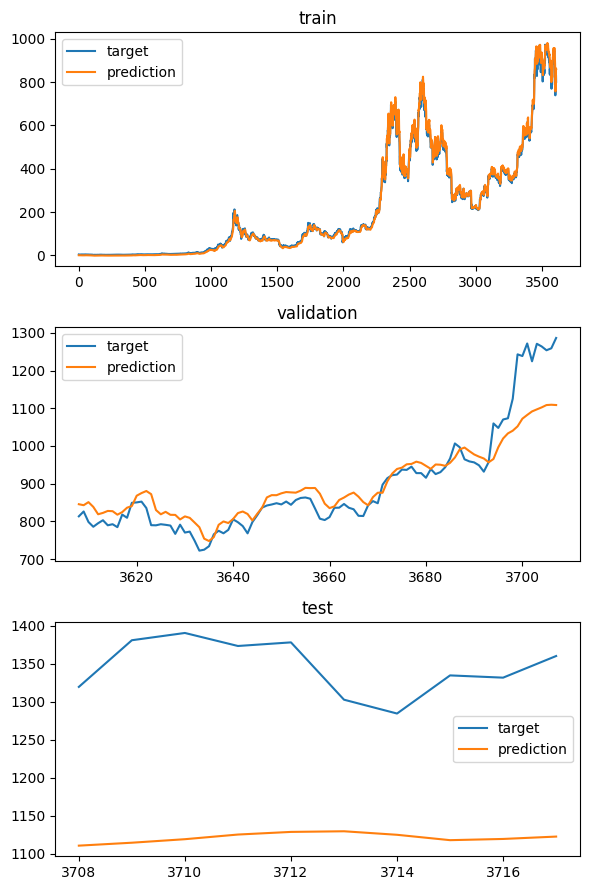

In [14]:
if __name__ == "__main__":
    import sys
    if 'ipykernel' in sys.modules:  # Jupyter Notebook에서 실행 중인지 확인
        # Jupyter에서 실행할 때는 기본값 사용
        class Args:
            def __init__(self):
                self.wandb = True
                self.batch_size = 32
                self.epochs = 100
                self.learning_rate = 0.001
                self.weight_decay = 0.0001
                self.validation_intervals = 1
                self.early_stop_patience = 5
                self.early_stop_delta = 0.001
        args = Args()
    else:
        # 일반 Python 스크립트로 실행할 때는 argparse 사용
        parser = get_parser()
        args = parser.parse_args()
    
    main(args)